<a href="https://colab.research.google.com/github/workingoncoding/DACON_-/blob/main/%5B%EB%B2%A0%EC%9D%B4%EC%8A%A4%EB%9D%BC%EC%9D%B8%5D_%EB%8D%B0%EC%9D%B4%EC%BD%98_%EB%B2%A0%EC%9D%B4%EC%8A%A4%EB%9D%BC%EC%9D%B8_%EC%BD%94%EB%93%9C_%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


작업폴더 경로 설정

In [ ]:
workspace_path = '/gdrive/My Drive/DACON/주차수요/parking_data'  # 과제 파일 업로드한 경로 반영

## 패키지

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib
import plotly.express as px

import matplotlib.pyplot as plt 
from matplotlib import font_manager as fm
from sklearn.model_selection import RepeatedKFold

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import lightgbm as LGB
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso,ElasticNet,Ridge
from sklearn.svm import SVR
from tqdm import tqdm

NanumBarunGothic


## 데이터

In [ ]:
import pandas as pd
import os

#train 데이터
train = pd.read_csv(os.path.join(workspace_path, 'train.csv'))

#test 데이터
test = pd.read_csv(os.path.join(workspace_path, 'test.csv'))

#age gender 데이터
age_gender = pd.read_csv(os.path.join(workspace_path, 'age_gender_info.csv'))

#submission 데이터
submission = pd.read_csv(os.path.join(workspace_path, 'sample_submission.csv'))

In [ ]:
train.shape, test.shape, age_gender.shape

((2952, 15), (1022, 14), (16, 23))

In [ ]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [ ]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          1022 non-null   object 
 1   총세대수                          1022 non-null   int64  
 2   임대건물구분                        1022 non-null   object 
 3   지역                            1022 non-null   object 
 4   공급유형                          1022 non-null   object 
 5   전용면적                          1022 non-null   float64
 6   전용면적별세대수                      1022 non-null   int64  
 7   공가수                           1022 non-null   float64
 8   자격유형                          1020 non-null   object 
 9   임대보증금                         842 non-null    object 
 10  임대료                           842 non-null    object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  980 non-null    float64
 12  도보 10분거리 내 버스정류장 수            1022 non-null   float64
 13  단지내

age_gender info

In [ ]:
ag = age_gender.set_index('지역')

In [ ]:
age_gender.loc[:,'지역'] = age_gender.loc[:,'지역'].astype('category').cat.codes

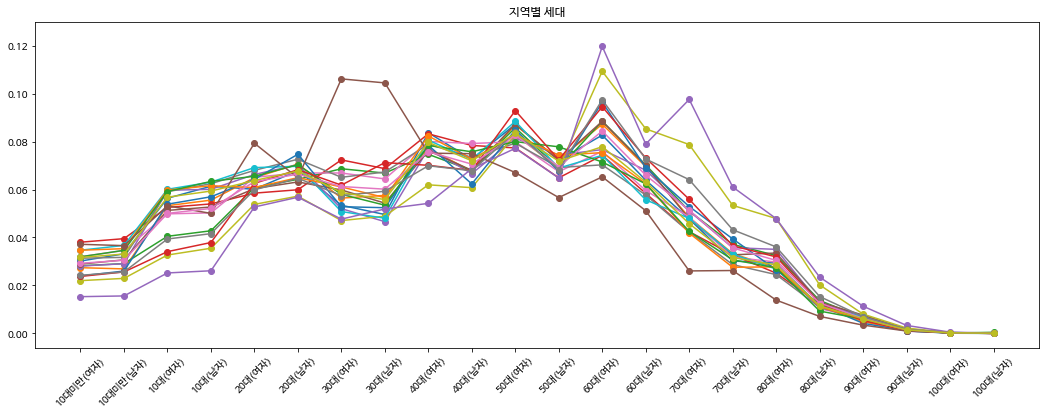

In [ ]:
fig = plt.figure(figsize = (18, 6))
plt.plot(ag.T, marker ='o', linestyle = 'solid')
plt.title('지역별 세대')
plt.xticks(rotation=45)
plt.ylim(top=0.13)
plt.show()

정규분포 모양
성별에 따라 편차가 존재함
남성보다는 여성이 높은 비율을 보이고 있음

세종특별시는 다른 지역과 다르게 30대에서 높은 비중 보임

서울, 부산 60대 여성, 70대 여성에서 peak

In [ ]:
age_gender = age_gender.drop(['10대미만(여자)'], axis =1)

In [ ]:
age_gender = age_gender.drop(['10대미만(남자)'], axis =1)

In [ ]:
age_gender = age_gender.drop(['10대(여자)'], axis =1)

In [ ]:
age_gender = age_gender.drop(['10대(남자)'], axis =1)

In [ ]:
age_gender

,지역,20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,3,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,2,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,6,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,0.085751,0.068819,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,1,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,12,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
5,0,0.060374,0.063157,0.059821,0.054321,0.076201,0.068002,0.087266,0.072177,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
6,4,0.065084,0.066875,0.066888,0.064416,0.080028,0.079183,0.079902,0.067443,0.075930,0.059586,0.048552,0.031754,0.029749,0.010341,0.006343,0.000895,0.000353,0.000013
7,14,0.067975,0.072622,0.065095,0.067303,0.078860,0.073418,0.079299,0.069167,0.070278,0.057692,0.042296,0.028682,0.024514,0.010900,0.005429,0.001549,0.000219,0.000123
8,7,0.053796,0.057233,0.047049,0.048866,0.061952,0.060769,0.082899,0.068855,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028
9,13,0.069135,0.069667,0.050808,0.048026,0.080548,0.072530,0.088403,0.068930,0.074248,0.055717,0.047944,0.033054,0.026836,0.011332,0.006832,0.000982,0.000368,0.000082


상관관계

In [ ]:
df=train.append(test)

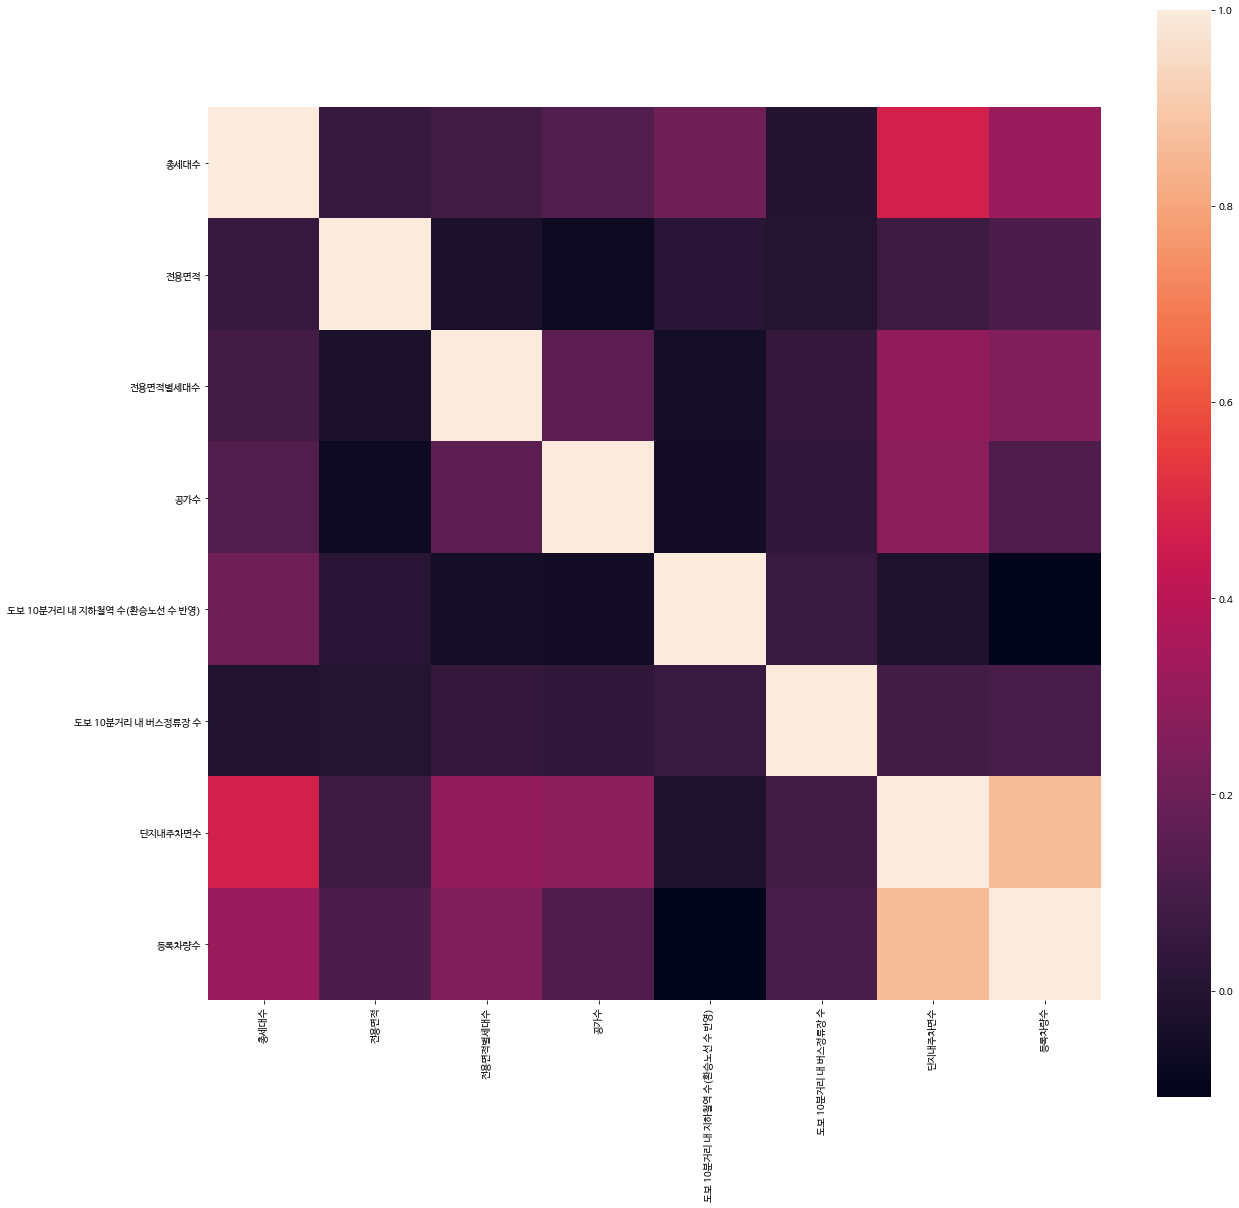

In [ ]:
corrmat = df.corr()
plt.subplots(figsize=(20,20))
sns.heatmap(corrmat, square=True)

c = corrmat.abs()

s = c.unstack()
so = s.sort_values(ascending=True).drop_duplicates()

## 결측치 확인

In [ ]:
train.isna().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [ ]:
test.isna().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     42
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

데이터 설명

train 데이터에서는 임대보증금, 임대료, 도보 10분거리 내 지하철역 수(환승노선 수 반영) 도보 10분거리 내 버스정류장 수에 NULL값 존재

test 데이터에서는 자격유형, 임대보증금, 임대료, 도보 10분거리 내 지하철역 수(환승노선 수 반영)에 NULL값 존재

아파트인지 상가인지 구분해봄.

In [ ]:
train_apart = train[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형', '임대보증금', '임대료']].loc[train['임대건물구분'] == '아파트']

In [ ]:
train_shop = train[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형']].loc[train['임대건물구분'] == '상가']

In [ ]:
train_danji = train[['단지코드', '총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수']].drop_duplicates()

In [ ]:
train_apart.shape, train_shop.shape, train_danji.shape

((2390, 8), (562, 6), (423, 8))

In [ ]:
test_apart = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형', '임대보증금', '임대료']].loc[test['임대건물구분'] == '아파트']

In [ ]:
test_shop = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형']].loc[test['임대건물구분'] == '상가']

In [ ]:
test_danji = test[['단지코드', '총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수']].drop_duplicates()

In [ ]:
test_apart.shape, test_shop.shape, test_danji.shape

((845, 8), (177, 6), (150, 7))

임대보증금, 임대료 '-'을 null로 바꾸고 float으로 타입 변경

In [ ]:
train.loc[train.임대보증금 == '-', '임대보증금'] = np.nan
test.loc[test.임대보증금 == '-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] == test['임대보증금'].astype(float)

train.loc[train.임대료 == '-', '임대료'] = np.nan
test.loc[test.임대료 == '-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] == test['임대료'].astype(float)

0       False
1       False
2       False
3       False
4       False
        ...  
1017    False
1018    False
1019    False
1020    False
1021    False
Name: 임대료, Length: 1022, dtype: bool

NULL 값(임대보증금, 임대료) 탐색

In [ ]:
train[train.임대보증금.isnull()].공급유형.value_counts()

임대상가    562
국민임대      8
공공분양      7
행복주택      4
Name: 공급유형, dtype: int64

In [ ]:
test[test.임대보증금.isnull()].공급유형.value_counts()

임대상가    177
영구임대      5
행복주택      4
Name: 공급유형, dtype: int64

In [ ]:
train[train.임대료.isnull()].자격유형.value_counts()

D    569
A      9
H      8
K      4
Name: 자격유형, dtype: int64

In [ ]:
test[test.임대료.isnull()].자격유형.value_counts()

D    180
L      4
C      2
Name: 자격유형, dtype: int64

NULL값 (도보 10분거리 내 지하철역 수, 도보 10분거리 내 버스정류장 수) 탐색

In [ ]:
train[train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()].단지코드.value_counts()

C1874    30
C1875    22
C1616    22
C2258    20
C1004    19
C1704    17
C1983    15
C1350    13
C2583    11
C2644     7
C2100     6
C1068     6
C1649     4
C1312     4
C1005     3
C1175     3
C1424     3
C2156     3
C2216     2
C2520     1
Name: 단지코드, dtype: int64

In [ ]:
subway_null_codes=train[train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()].단지코드.unique()
train.loc[train.단지코드.isin(subway_null_codes), '도보 10분거리 내 지하철역 수(환승노선 수 반영)'].value_counts(dropna=False)

NaN    211
Name: 도보 10분거리 내 지하철역 수(환승노선 수 반영), dtype: int64

In [ ]:
test[test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()].단지코드.value_counts()

C2177    25
C1472     5
C1083     5
C1327     4
C1318     3
Name: 단지코드, dtype: int64

In [ ]:
subway_null_codes = test[test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()].단지코드.unique()
test.loc[test.단지코드.isin(subway_null_codes), '도보 10분거리 내 지하철역 수(환승노선 수 반영)'].value_counts(dropna=False)

NaN    42
Name: 도보 10분거리 내 지하철역 수(환승노선 수 반영), dtype: int64

In [ ]:
print('전체 단지 수: ', train['단지코드'].nunique())
print('지하철 결측치 단지 수: ', train.loc[train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()]['단지코드'].nunique())
print('지하철 결측치 단지: ', train.loc[train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()]['단지코드'].unique())
print('지하철 결측치 단지 지역: ', train.loc[train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()]['지역'].unique())

전체 단지 수:  423
지하철 결측치 단지 수:  20
지하철 결측치 단지:  ['C1312' 'C1874' 'C1424' 'C2100' 'C2520' 'C1616' 'C1704' 'C2258' 'C1068'
 'C1983' 'C2216' 'C2644' 'C1005' 'C1004' 'C1875' 'C2156' 'C1175' 'C2583'
 'C1649' 'C1350']
지하철 결측치 단지 지역:  ['충청남도' '대전광역시' '경상남도']


In [ ]:
print('전체 단지 수: ', test['단지코드'].nunique())
print('지하철 결측치 단지 수: ', test.loc[test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()]['단지코드'].nunique())
print('지하철 결측치 단지: ', test.loc[test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()]['단지코드'].unique())
print('지하철 결측치 단지 지역: ', test.loc[test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()]['지역'].unique())

전체 단지 수:  150
지하철 결측치 단지 수:  5
지하철 결측치 단지:  ['C1472' 'C1083' 'C2177' 'C1318' 'C1327']
지하철 결측치 단지 지역:  ['충청남도' '대전광역시']


In [ ]:
train[train['도보 10분거리 내 버스정류장 수'].isnull()].단지코드.value_counts()

C1649    4
Name: 단지코드, dtype: int64

In [ ]:
bus_null_codes = train[train['도보 10분거리 내 버스정류장 수'].isnull()].단지코드.unique()
train.loc[train.단지코드.isin(bus_null_codes), '도보 10분거리 내 버스정류장 수'].value_counts(dropna=False)

NaN    4
Name: 도보 10분거리 내 버스정류장 수, dtype: int64

In [ ]:
test[test['도보 10분거리 내 버스정류장 수'].isnull()].단지코드.value_counts()

Series([], Name: 단지코드, dtype: int64)

In [ ]:
bus_null_codes = test[test['도보 10분거리 내 버스정류장 수'].isnull()].단지코드.unique()
test.loc[test.단지코드.isin(bus_null_codes), '도보 10분거리 내 버스정류장 수'].value_counts(dropna=False)

Series([], Name: 도보 10분거리 내 버스정류장 수, dtype: int64)

In [ ]:
train.loc[train['도보 10분거리 내 버스정류장 수'].isnull()]['지역'].unique()

array(['경상남도'], dtype=object)

In [ ]:
print('전체 단지 수: ', train['단지코드'].nunique())
print('버스 결측치 단지 수: ', train.loc[train['도보 10분거리 내 버스정류장 수'].isnull()]['단지코드'].nunique())
print('버스 결측치 단지: ', train.loc[train['도보 10분거리 내 버스정류장 수'].isnull()]['단지코드'].unique())
print('버스 결측치 단지 지역: ', train.loc[train['도보 10분거리 내 버스정류장 수'].isnull()]['지역'].unique())

전체 단지 수:  423
버스 결측치 단지 수:  1
버스 결측치 단지:  ['C1649']
버스 결측치 단지 지역:  ['경상남도']


In [ ]:
print('전체 단지 수: ', test['단지코드'].nunique())
print('버스 결측치 단지 수: ', test.loc[test['도보 10분거리 내 버스정류장 수'].isnull()]['단지코드'].nunique())
print('버스 결측치 단지: ', test.loc[test['도보 10분거리 내 버스정류장 수'].isnull()]['단지코드'].unique())
print('버스 결측치 단지 지역: ', test.loc[test['도보 10분거리 내 버스정류장 수'].isnull()]['지역'].unique())

전체 단지 수:  150
버스 결측치 단지 수:  0
버스 결측치 단지:  []
버스 결측치 단지 지역:  []


NULL값 (자격유형) 탐색!

In [ ]:
test[test.자격유형.isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


In [ ]:
test[test.자격유형.isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


임대료, 임대보증금 null값 처리 0으로!

In [ ]:
train.loc[train['공급유형'] == '공공분양', '임대료'] = train['임대료'].fillna(0)
train.loc[train['공급유형'] == '장기전세', '임대료'] = train['임대료'].fillna(0)
train.loc[train['공급유형'] == '국민임대', '임대료'] = train['임대료'].fillna(0)
train.loc[train['공급유형'] == '행복주택', '임대료'] = train['임대료'].fillna(0)

train.loc[train['공급유형'] == '공공분양', '임대보증금'] = train['임대보증금'].fillna(0)
train.loc[train['공급유형'] == '장기전세', '임대보증금'] = train['임대보증금'].fillna(0)
train.loc[train['공급유형'] == '국민임대', '임대보증금'] = train['임대보증금'].fillna(0)
train.loc[train['공급유형'] == '행복주택', '임대보증금'] = train['임대보증금'].fillna(0)

In [ ]:
train.groupby(['공급유형'], as_index=False)['임대료'].mean()

,공급유형,임대료
0,공공분양,0.000000
1,공공임대(10년),521286.780488
2,공공임대(50년),201579.677419
3,공공임대(5년),400000.000000
4,공공임대(분납),288816.666667
5,국민임대,172611.575654
6,영구임대,93913.750000
7,임대상가,NaN
8,장기전세,0.000000
9,행복주택,125734.788732


In [ ]:
#임대 상가의 임대료 처리
train.loc[train['지역'] == '부산광역시', '임대료'] = train['임대료'].fillna(train[train['지역'] == '부산광역시']['임대료'].mean())
train.loc[train['지역'] == '대전광역시', '임대료'] = train['임대료'].fillna(train[train['지역'] == '대전광역시']['임대료'].mean())
train.loc[train['지역'] == '경상남도', '임대료'] = train['임대료'].fillna(train[train['지역'] == '경상남도']['임대료'].mean())
train.loc[train['지역'] == '충청남도', '임대료'] = train['임대료'].fillna(train[train['지역'] == '충청남도']['임대료'].mean())
train.loc[train['지역'] == '강원도', '임대료'] = train['임대료'].fillna(train[train['지역'] == '강원도']['임대료'].mean())
train.loc[train['지역'] == '제주특별자치도', '임대료'] = train['임대료'].fillna(train[train['지역'] == '제주특별자치도']['임대료'].mean())

train.loc[train['지역'] == '부산광역시', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '부산광역시']['임대보증금'].mean())
train.loc[train['지역'] == '대전광역시', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '대전광역시']['임대보증금'].mean())
train.loc[train['지역'] == '경상남도', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '경상남도']['임대보증금'].mean())
train.loc[train['지역'] == '충청남도', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '충청남도']['임대보증금'].mean())
train.loc[train['지역'] == '강원도', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '강원도']['임대보증금'].mean())
train.loc[train['지역'] == '제주특별자치도', '임대보증금'] = train['임대보증금'].fillna(train[train['지역'] == '제주특별자치도']['임대보증금'].mean())

In [ ]:
train.groupby(['공급유형'], as_index = False)['임대료'].mean()

,공급유형,임대료
0,공공분양,0.000000
1,공공임대(10년),521286.780488
2,공공임대(50년),201579.677419
3,공공임대(5년),400000.000000
4,공공임대(분납),288816.666667
5,국민임대,172611.575654
6,영구임대,93913.750000
7,임대상가,169629.773379
8,장기전세,0.000000
9,행복주택,125734.788732


지하철,버스 null 값 처리 0으로!

In [ ]:
cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

In [ ]:
train.isna().sum()

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            0
임대보증금                           0
임대료                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
등록차량수                           0
dtype: int64

In [ ]:
test.isna().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           186
임대료                             186
도보 10분거리 내 지하철역 수(환승노선 수 반영)      0
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

자격유형 null 처리

In [ ]:
test[test.단지코드=='C2411']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0.0,2.0,840.0


In [ ]:
test[test.단지코드=='C2253']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0.0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0.0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0.0,2.0,173.0
263,C2253,1161,상가,강원도,임대상가,22.91,1,0.0,D,NaN,NaN,0.0,2.0,173.0
264,C2253,1161,상가,강원도,임대상가,23.79,1,0.0,D,NaN,NaN,0.0,2.0,173.0
265,C2253,1161,상가,강원도,임대상가,23.79,1,0.0,D,NaN,NaN,0.0,2.0,173.0
266,C2253,1161,상가,강원도,임대상가,23.86,1,0.0,D,NaN,NaN,0.0,2.0,173.0
267,C2253,1161,상가,강원도,임대상가,23.86,1,0.0,D,NaN,NaN,0.0,2.0,173.0


TEST 자격유형 NULL값 처리

In [ ]:
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'

In [ ]:
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

면적 변경

In [ ]:
train['전용면적'] = train['전용면적'] //10*10

In [ ]:
test['전용면적'] = test['전용면적'] //10*10

In [ ]:
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,30.0,134,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,30.0,15,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,50.0,385,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,50.0,15,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,50.0,41,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,강원도,국민임대,40.0,19,7.0,A,11346000.0,116090.0,0.0,1.0,166.0,146.0
2948,C2532,239,아파트,강원도,국민임대,50.0,34,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0
2949,C2532,239,아파트,강원도,국민임대,50.0,34,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0
2950,C2532,239,아파트,강원도,국민임대,50.0,114,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0


In [ ]:
train.drop(['총세대수'], axis=1)

,단지코드,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,아파트,경상북도,국민임대,30.0,134,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0
1,C2483,아파트,경상북도,국민임대,30.0,15,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0
2,C2483,아파트,경상북도,국민임대,50.0,385,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
3,C2483,아파트,경상북도,국민임대,50.0,15,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
4,C2483,아파트,경상북도,국민임대,50.0,41,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,아파트,강원도,국민임대,40.0,19,7.0,A,11346000.0,116090.0,0.0,1.0,166.0,146.0
2948,C2532,아파트,강원도,국민임대,50.0,34,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0
2949,C2532,아파트,강원도,국민임대,50.0,34,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0
2950,C2532,아파트,강원도,국민임대,50.0,114,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0


변수 차집합, 처리

In [ ]:
columns = ['임대건물구분', '지역', '공급유형', '자격유형']
for col in columns:
    complement = list(set(train[col].unique()) - set(test[col].unique()))
    print(f"Train 데이터 기준 차집합 {col} : {complement}")

Train 데이터 기준 차집합 임대건물구분 : []
Train 데이터 기준 차집합 지역 : ['서울특별시']
Train 데이터 기준 차집합 공급유형 : ['공공임대(5년)', '장기전세', '공공분양']
Train 데이터 기준 차집합 자격유형 : ['O', 'F', 'B']


In [ ]:
train = train.loc[train.지역 != '서울특별시']

mask = train.공급유형 != '공공분양'
mask &= train.공급유형 != '장기전세'
mask &= train.공급유형 != '공공임대(5년)'

train = train.loc[mask]

In [ ]:
    mask = train.자격유형 != 'F'
    mask &= train.자격유형 != 'B'
    mask &= train.자격유형 != 'O'
    train = train.loc[mask]

In [ ]:
data = pd.concat([train, test])
data.shape

(3875, 15)

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3875 entries, 0 to 1021
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          3875 non-null   object 
 1   총세대수                          3875 non-null   int64  
 2   임대건물구분                        3875 non-null   object 
 3   지역                            3875 non-null   object 
 4   공급유형                          3875 non-null   object 
 5   전용면적                          3875 non-null   float64
 6   전용면적별세대수                      3875 non-null   int64  
 7   공가수                           3875 non-null   float64
 8   자격유형                          3875 non-null   object 
 9   임대보증금                         3689 non-null   object 
 10  임대료                           3689 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  3875 non-null   float64
 12  도보 10분거리 내 버스정류장 수            3875 non-null   float64
 13  단지내

In [ ]:
data.describe()

,총세대수,전용면적,전용면적별세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
count,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,3875.000000,2853.000000
mean,881.120258,38.356129,102.008774,13.713290,0.154065,3.939355,581.160258,548.132843
std,522.630169,33.448458,130.354669,10.952501,0.418044,3.623788,380.520972,424.651581
min,26.000000,0.000000,1.000000,0.000000,0.000000,0.000000,13.000000,13.000000
25%,504.000000,30.000000,14.000000,4.000000,0.000000,2.000000,277.000000,209.000000
50%,775.000000,30.000000,60.000000,13.000000,0.000000,3.000000,490.000000,460.000000
75%,1117.000000,50.000000,143.500000,21.000000,0.000000,4.000000,802.000000,763.000000
max,2572.000000,580.000000,1865.000000,55.000000,3.000000,50.000000,1798.000000,2550.000000


단지 하나에 하나의 값만 존재하는 컬럼들만 뽑아서 새로운 데이터 프레임 생성

In [ ]:
unique_cols = ['총세대수', '지역', '공가수', 
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

In [ ]:
train_agg

,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
단지코드,,,,,,,
C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0
C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0
C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0
C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0
C1898,566,전라북도,9.0,0.0,6.0,517.0,415.0
...,...,...,...,...,...,...,...
C2586,90,제주특별자치도,7.0,0.0,3.0,66.0,57.0
C2035,492,강원도,24.0,0.0,1.0,521.0,246.0
C2020,40,부산광역시,7.0,1.0,2.0,25.0,19.0


In [ ]:
train.groupby(['단지코드']).nunique(dropna=False)

,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
단지코드,,,,,,,,,,,,,,
C1000,1,1,1,1,3,6,1,1,3,3,1,1,1,1
C1004,1,2,1,2,5,3,1,2,3,3,1,1,1,1
C1005,1,1,1,1,1,3,1,1,3,3,1,1,1,1
C1013,1,1,1,1,3,5,1,1,3,3,1,1,1,1
C1014,1,1,1,1,3,7,1,1,4,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2663,1,1,1,1,4,6,1,1,4,4,1,1,1,1
C2666,1,1,1,1,2,6,1,1,2,2,1,1,1,1
C2670,1,1,1,1,2,3,1,1,3,3,1,1,1,1


In [ ]:
train.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)

총세대수                             411
임대건물구분                           444
지역                               411
공급유형                             470
전용면적                            1078
전용면적별세대수                        2137
공가수                              411
자격유형                             493
임대보증금                           1224
임대료                             1240
도보 10분거리 내 지하철역 수(환승노선 수 반영)     411
도보 10분거리 내 버스정류장 수               411
단지내주차면수                          411
등록차량수                            411
dtype: int64

In [ ]:
test.groupby(['단지코드']).nunique(dropna=False)

,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
단지코드,,,,,,,,,,,,,
C1003,1,1,1,1,4,8,1,1,5,5,1,1,1
C1006,1,2,1,2,5,7,1,2,3,3,1,1,1
C1016,1,1,1,1,3,4,1,1,3,3,1,1,1
C1019,1,1,1,1,2,4,1,1,2,2,1,1,1
C1030,1,1,1,1,3,3,1,1,3,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2653,1,1,1,1,1,4,1,1,2,2,1,1,1
C2675,1,1,1,1,3,8,1,1,3,3,1,1,1
C2676,1,2,1,2,8,4,1,2,3,3,1,1,1


In [ ]:
test.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)

총세대수                            150
임대건물구분                          157
지역                              150
공급유형                            167
전용면적                            399
전용면적별세대수                        797
공가수                             150
자격유형                            178
임대보증금                           459
임대료                             461
도보 10분거리 내 지하철역 수(환승노선 수 반영)    150
도보 10분거리 내 버스정류장 수              150
단지내주차면수                         150
dtype: int64

In [ ]:
# fig = px.scatter(df_all, x="총세대수", y="단지내주차면수",  color="type", trendline="ols", hover_data=['단지코드'], marginal_x="box",marginal_y="box",)
# fig.update_layout(width=600,
#                   height=600,
#                   hovermode='closest')
# fig.show()

In [ ]:
# fig = px.scatter(df_all, x="전용면적", y="단지내주차면수",  color="type", trendline="ols", hover_data=['단지코드'], marginal_x="box",marginal_y="box",)
# fig.update_layout(width=600,
#                   height=600,
#                   hovermode='closest')
# fig.show()

In [ ]:
# fig = px.scatter(df_all, x="공가수", y="단지내주차면수",  color="type", trendline="ols", hover_data=['단지코드'], marginal_x="box",marginal_y="box",)
# fig.update_layout(width=600,
#                   height=600,
#                   hovermode='closest')
# fig.show()

In [ ]:
# fig = px.scatter(df_all, x="도보 10분거리 내 버스정류장 수", y="단지내주차면수",  color="type", trendline="ols", hover_data=['단지코드'], marginal_x="box",marginal_y="box",)
# fig.update_layout(width=600,
#                   height=600,
#                   hovermode='closest')
# fig.show()

In [ ]:
# fig = px.scatter(df_all, x="도보 10분거리 내 지하철역 수(환승노선 수 반영)", y="단지내주차면수",  color="type", trendline="ols", hover_data=['단지코드'], marginal_x="box",marginal_y="box",)
# fig.update_layout(width=600,
#                   height=600,
#                   hovermode='closest')
# fig.show()

In [ ]:
corr = train.drop(['단지코드'],1,).corr()["등록차량수"].abs().sort_values(ascending=False)
corr

등록차량수                           1.000000
단지내주차면수                         0.853826
임대료                             0.409688
총세대수                            0.327998
임대보증금                           0.317207
전용면적별세대수                        0.266611
공가수                             0.150375
도보 10분거리 내 버스정류장 수              0.102569
전용면적                            0.083832
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0.083431
Name: 등록차량수, dtype: float64

총세대수, 지역, 공가수, 지하철역 수, 버스정류장 수, 단지내 주차면수, 등록차량수 unique!!

In [ ]:
data['주차면수대비등록차량비율'] = data['등록차량수']/data['단지내주차면수']
data['주차면수대비총세대수비율'] = data['총세대수']/data['단지내주차면수']
data['거주율'] = 1- (data['공가수']/data['총세대수'])
data['거주율99%이상'] = data['거주율'].apply(lambda x: 1 if x>=0.95 else 0)

임대건물구분 상가 아파트

상가 당 주차수요와 일반 주차수요 구분

In [ ]:
def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

In [ ]:
reshape_cat_features(data=train, cast_col='지역', value_col='counter')

,지역_강원도,지역_경기도,지역_경상남도,지역_경상북도,지역_광주광역시,지역_대구광역시,지역_대전광역시,지역_부산광역시,지역_세종특별자치시,지역_울산광역시,지역_전라남도,지역_전라북도,지역_제주특별자치도,지역_충청남도,지역_충청북도
단지코드,,,,,,,,,,,,,,,
C1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
C1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
C1013,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter')

,임대건물구분_상가,임대건물구분_아파트
단지코드,,
C1000,0.0,1.0
C1004,1.0,1.0
C1005,0.0,1.0
C1013,0.0,1.0
C1014,0.0,1.0
...,...,...
C2663,0.0,1.0
C2666,0.0,1.0
C2670,0.0,1.0


In [ ]:
reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter')

,임대건물구분_상가,임대건물구분_아파트
단지코드,,
C1003,0.0,1.0
C1006,1.0,1.0
C1016,0.0,1.0
C1019,0.0,1.0
C1030,0.0,1.0
...,...,...
C2653,0.0,1.0
C2675,0.0,1.0
C2676,1.0,1.0


In [ ]:
print('전체 단지 수: ', train['단지코드'].nunique())
print('상가 보유 단지 수: ', train.loc[train['임대건물구분'] == '상가']['단지코드'].nunique())
print('상가 보유 단지: ', train.loc[train['임대건물구분'] == '상가']['단지코드'].unique())
print('상가 보유 단지 지역: ', train.loc[train['임대건물구분'] == '상가']['지역'].unique())

전체 단지 수:  411
상가 보유 단지 수:  33
상가 보유 단지:  ['C1925' 'C1874' 'C2416' 'C2621' 'C1616' 'C1704' 'C2258' 'C2038' 'C1859'
 'C1722' 'C2190' 'C1476' 'C1983' 'C2135' 'C2034' 'C1109' 'C2289' 'C2597'
 'C2310' 'C2132' 'C1439' 'C1899' 'C1056' 'C2644' 'C1206' 'C1775' 'C1790'
 'C2109' 'C1698' 'C1004' 'C1875' 'C2212' 'C2571']
상가 보유 단지 지역:  ['강원도' '충청남도' '경상남도' '대전광역시' '부산광역시' '제주특별자치도']


In [ ]:
print('전체 단지 수: ', train['단지코드'].nunique())
print('상가 보유 단지 수: ', train.loc[train['임대건물구분'] == '아파트']['단지코드'].nunique())
print('상가 보유 단지: ', train.loc[train['임대건물구분'] == '아파트']['단지코드'].unique())
print('상가 보유 단지 지역: ', train.loc[train['임대건물구분'] == '아파트']['지역'].unique())

전체 단지 수:  411
상가 보유 단지 수:  411
상가 보유 단지:  ['C2483' 'C2515' 'C1407' 'C1470' 'C1898' 'C1244' 'C1171' 'C2073' 'C2513'
 'C1936' 'C2049' 'C2202' 'C1925' 'C2576' 'C1312' 'C1874' 'C2650' 'C2416'
 'C2013' 'C1424' 'C2100' 'C2621' 'C2520' 'C2319' 'C1616' 'C1704' 'C2258'
 'C1032' 'C2038' 'C1859' 'C1722' 'C1850' 'C2190' 'C1476' 'C1077' 'C1068'
 'C1983' 'C2135' 'C2034' 'C1109' 'C1497' 'C2289' 'C2597' 'C2310' 'C1672'
 'C2132' 'C1439' 'C1613' 'C2216' 'C1899' 'C1056' 'C2644' 'C1206' 'C2481'
 'C1718' 'C1655' 'C1430' 'C1775' 'C1519' 'C2221' 'C1790' 'C2109' 'C1698'
 'C1866' 'C1005' 'C1004' 'C1875' 'C2156' 'C2212' 'C2401' 'C2571' 'C1175'
 'C1833' 'C2445' 'C1885' 'C2368' 'C2016' 'C2371' 'C2536' 'C2538' 'C1014'
 'C1592' 'C1867' 'C2326' 'C1015' 'C1620' 'C1049' 'C2000' 'C2097' 'C1668'
 'C1689' 'C1234' 'C2514' 'C1368' 'C1057' 'C2336' 'C1026' 'C2256' 'C1900'
 'C2666' 'C2361' 'C1642' 'C1013' 'C2232' 'C1973' 'C2458' 'C2574' 'C2133'
 'C2096' 'C2010' 'C1879' 'C1131' 'C1468' 'C1213' 'C1173' 'C2492' 'C2032'
 'C2094' 

In [ ]:
set(train.공급유형)

{'공공임대(10년)', '공공임대(50년)', '공공임대(분납)', '국민임대', '영구임대', '임대상가', '행복주택'}

-----------잘된걸 볼수있다---------------

특정자격 유형이 많으면 그 단지는 등록차량수가 적을 것이다.
예를들어, 소득수준이 낮은 자격유형의 세대가 많으면 주차수요가 적을 가능성이 높을 것으로 예상해볼 수 있다.

In [ ]:
# sns.barplot(data=train.groupby(['자격유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False),
#             x=train.groupby(['자격유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False).index, y='전용면적별세대수')
# plt.title('자격유형별 총세대수 총합')
# plt.xticks(rotation=90)
# plt.show()

중복확인!!

In [ ]:
train.shape, train.drop_duplicates().shape # 중복 존재

((2853, 15), (2348, 15))

In [ ]:
test.shape, test.drop_duplicates().shape # 중복 존재

((1022, 14), (866, 14))

In [ ]:
###중복데이터는 제거한다
train = train.drop_duplicates()
test = test.drop_duplicates()

In [ ]:
train.shape, test.shape

((2348, 15), (866, 14))

카테고리화!!!!!!!1

In [ ]:
# train.loc[:,'임대용총전용면적'] = train.loc[:,'전용면적'] * train.loc[:,'전용면적별세대수']
# train.loc[:,"임대건물구분"] = train.loc[:,"임대건물구분"].astype('category').cat.codes
# train.loc[:,'지역'] = train.loc[:,'지역'].astype('category').cat.codes
# train.loc[:,'공급유형'] = train.loc[:,'공급유형'].astype('category').cat.codes
# train.loc[:,'자격유형'] = train.loc[:,'자격유형'].astype('category').cat.codes
# train['key'] = train['임대건물구분'].astype(str).str.cat(train['공급유형'].astype(str), sep='-').str.cat(train['자격유형'].astype(str), sep='-')

In [ ]:
# test.loc[:,'임대용총전용면적'] = test.loc[:,'전용면적'] * test.loc[:,'전용면적별세대수']
# test.loc[:,"임대건물구분"] = test.loc[:,"임대건물구분"].astype('category').cat.codes
# test.loc[:,'지역'] = test.loc[:,'지역'].astype('category').cat.codes
# test.loc[:,'공급유형'] = test.loc[:,'공급유형'].astype('category').cat.codes
# test.loc[:,'자격유형'] = test.loc[:,'자격유형'].astype('category').cat.codes
# test['key'] = test['임대건물구분'].astype(str).str.cat(test['공급유형'].astype(str), sep='-').str.cat(test['자격유형'].astype(str), sep='-')

총세대수는 상가 세대수까지 합친 숫자입니다.

상가가 누락되어 부족한 것도 아닙니다. 그냥 안 맞습니다.
제공된 데이터는 해당 단지의 모든 정보를 담고 있는 것은 아닌 것 같습니다.
누락된 세대수를 어떻게 해결할지 고민을 해봐야할 것 같습니다.

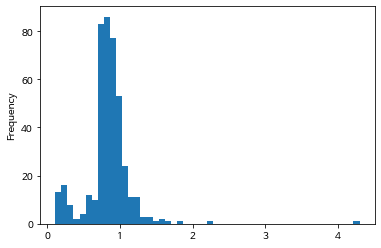

In [ ]:
(train_danji['단지내주차면수'] / train_danji['총세대수']).plot(kind='hist', bins=50)

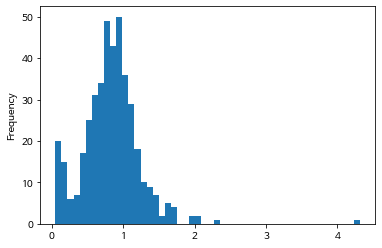

In [ ]:
(train_danji['등록차량수'] / train_danji['총세대수']).plot(kind='hist', bins=50)

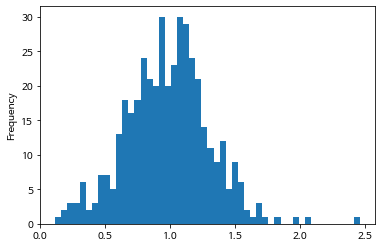

In [ ]:
(train_danji['등록차량수'] / train_danji['단지내주차면수']).plot(kind='hist', bins=50)

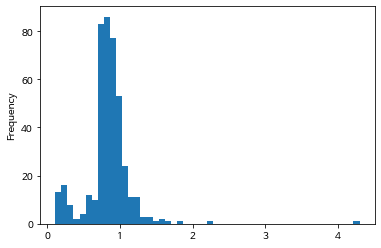

In [ ]:
(train_danji['단지내주차면수'] / train_danji['총세대수']).plot(kind='hist', bins=50)

단지내 주차면수/ 총세대수는 1을 평균으로 정규분포
0에 가까운 단지들 존재, 4가 넘는 것도 있음

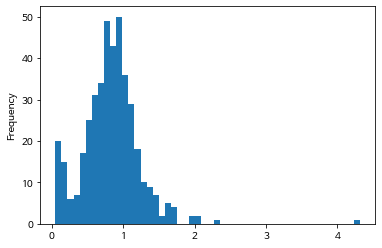

In [ ]:
(train_danji['등록차량수'] / train_danji['총세대수']).plot(kind='hist', bins=50)

결과 파일 생성

지역 매핑

In [ ]:
local_map = {}
for i, loc in enumerate(train_agg['지역'].unique()):
    local_map[loc] = i

In [ ]:
train_agg['지역'] = train_agg['지역'].map(local_map)
test_agg['지역'] = test_agg['지역'].map(local_map)

In [ ]:
x_train = train_agg.iloc[:, 1:-1]
y_train = train_agg.iloc[:,-1]
x_test = test_agg.iloc[:,1:]

In [ ]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
pred = model.predict(x_test)

In [ ]:
submission['num'] = pred

In [ ]:
pred

array([ 694.41 , 1364.99 ,  587.79 ,  543.94 , 1055.27 , 1728.92 ,
        890.68 ,  440.41 ,  382.326,  291.04 ,  542.42 ,  343.16 ,
        267.88 ,  306.69 ,  379.47 ,  286.75 ,  424.57 ,  450.56 ,
        211.23 ,  855.81 ,  322.18 ,  438.124,  405.08 ,  528.12 ,
        396.51 ,  171.16 ,  151.9  ,  480.48 ,  489.62 ,  423.11 ,
        906.97 ,  120.32 ,  480.72 ,  335.81 ,   83.24 ,  273.41 ,
        507.36 ,  608.6  ,  848.14 ,  294.3  ,  463.67 ,  423.07 ,
        447.41 ,  404.71 ,  822.64 , 1178.59 ,  514.94 ,  698.81 ,
        389.34 ,  422.126,  779.17 ,  307.14 ,  986.76 ,  679.5  ,
        503.13 ,  296.89 ,  449.48 ,  300.55 ,  398.23 ,  105.65 ,
        375.165,  515.84 ,  969.03 ,  370.16 ,  113.46 ,  428.91 ,
        585.87 ,  870.49 ,  694.27 ,  507.79 ,  812.26 ,  323.18 ,
        624.27 ,  755.32 ,  957.1  ,  278.572,  727.5  , 1172.87 ,
        520.81 , 1045.56 ,  769.64 , 1037.53 ,  304.62 ,  320.11 ,
        331.92 ,  272.71 ,  260.96 ,  428.9  ,  254.74 , 1083.

In [ ]:
!pip install catboost

In [ ]:
cat_features = ['지역']
target_col = '등록차량수'

In [ ]:
from catboost import CatBoostRegressor
catb = CatBoostRegressor(
         cat_features=cat_features,
         loss_function='MAE',
         n_estimators=500, 
         learning_rate=0.05, 
         random_state=42
    )
    
catb.fit(train_agg.drop(columns=[target_col]), train_agg[target_col], verbose=100)

0:	learn: 278.9992689	total: 2.06ms	remaining: 1.03s
100:	learn: 108.2865529	total: 137ms	remaining: 543ms
200:	learn: 82.2404688	total: 296ms	remaining: 440ms
300:	learn: 69.3113325	total: 451ms	remaining: 298ms
400:	learn: 60.6657732	total: 596ms	remaining: 147ms
499:	learn: 55.0805453	total: 752ms	remaining: 0us


In [ ]:
submission.head()

,code,num
0,C1072,694.41
1,C1128,1364.99
2,C1456,587.79
3,C1840,543.94
4,C1332,1055.27


In [ ]:
submission['num'] = catb.predict(test_agg)

In [ ]:
submission

,code,num
0,C1072,747.065965
1,C1128,1301.485774
2,C1456,614.672165
3,C1840,526.069630
4,C1332,1177.238420
...,...,...
145,C2456,285.081868
146,C1266,482.028478
147,C2152,49.183929
148,C1267,371.716544


In [ ]:
submission.to_csv(os.path.join(workspace_path, 'submission___2.csv'),index = False)